# Testing non parametric functions

In [1]:
# Import Libraries - Enhanced for Statistical Analysis
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Set Up Database Connection
# Replace the placeholders with your actual database credentials
DB_CONFIG = {
    "dbname": "csgo_parsed",
    "user": "csgo_parser",
    "password": "3?6B7yTGPrkJF34p",
    "host": "192.168.1.100",
    "port": "5444"
}

In [2]:


# Ensure we have a fresh connection
try:
    conn = psycopg2.connect(**DB_CONFIG)
    print("✅ Database connection established")
except Exception as e:
    print(f"❌ Connection error: {e}")


print("📊 Helper functions defined successfully!")

✅ Database connection established
📊 Helper functions defined successfully!


In [3]:
# Query for detailed round outcomes
query_detailed = """
WITH round_equipment AS (
    SELECT 
        r.id,
        r.match_id,
        r.id_demo_exports,
        r.round_num,
        r.ct_winner,
        r.team1_winner,
        r.is_ct_t1,
        r.round_end_reason,
        -- CT team equipment
        SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) as ct_equipment,
        -- T team equipment
        SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) as t_equipment,
        hmi.team_1_id,
        hmi.team_2_id,
        hmi.event_id
    FROM rounds_ed r
    JOIN player_round_ed pr ON r.id = pr.round_id
    LEFT JOIN hltv_match_info hmi ON r.match_id = hmi.match_id
    WHERE pr.eq_val_fte > 0
    GROUP BY 1,2,3,4,5,6,7,8, 11,12,13
),
bomb_planted AS (
    SELECT 
        round_id,
        CASE WHEN COUNT(*) > 0 THEN 1 ELSE 0 END as bomb_planted
    FROM bomb_events_round_ed
    WHERE bomb_event_type = 0
    GROUP BY round_id
),
round_survivors AS (
    SELECT 
        r.id as round_id,
        r.is_ct_t1,
        -- Count total players per team (5 players each)
        -- CT survivors = 5 - (deaths of CT players)
        5 - COUNT(DISTINCT CASE 
            WHEN (r.is_ct_t1 = (pv.team = 1)) THEN k.victim_hltv_id 
        END) as ct_survivors,
        -- T survivors = 5 - (deaths of T players)
        5 - COUNT(DISTINCT CASE 
            WHEN (r.is_ct_t1 != (pv.team = 1)) THEN k.victim_hltv_id 
        END) as t_survivors
    FROM rounds_ed r
    LEFT JOIN kills_round_ed k ON r.id = k.round_id
    LEFT JOIN player_round_ed pv ON k.victim_hltv_id = pv.player_id AND k.round_id = pv.round_id and pv.player_id != 0
    GROUP BY 1,2
),
saved_equipment AS (
    SELECT 
        r.id as round_id,
        r.is_ct_t1,
        -- CT team saved equipment from player_economy_ed joined with player_round_ed
        SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN COALESCE(pe.saved_eq_val, 0) ELSE 0 END) as ct_saved_equipment,
        -- T team saved equipment from player_economy_ed joined with player_round_ed
        SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN COALESCE(pe.saved_eq_val, 0) ELSE 0 END) as t_saved_equipment
    FROM rounds_ed r
    JOIN player_economy_ed pe ON r.id = pe.round_id
    JOIN player_round_ed pr ON r.id = pr.round_id AND pe.player_id = pr.player_id and pr.player_id != 0
    GROUP BY 1,2
),
player_money AS (
    SELECT 
        r.id as round_id,
        r.is_ct_t1,
        -- CT team player money (money_earned + money_earned_re) joined with player_round_ed
        SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) 
            THEN COALESCE(pe.money_earned, 0)
            ELSE 0 END) as ct_player_money,
        -- T team player money (money_earned + money_earned_re) joined with player_round_ed
        SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) 
            THEN COALESCE(pe.money_earned, 0)  
            ELSE 0 END) as t_player_money
    FROM rounds_ed r
    JOIN player_economy_ed pe ON r.id = pe.round_id
    JOIN player_round_ed pr ON r.id = pr.round_id AND pe.player_id = pr.player_id and pr.player_id != 0
    GROUP BY 1,2
), 
ranked_data AS (
    SELECT 
        trd.id,
        trd.id_demo_exports,
        trd.round_num,
        trd.team1_winner,
        -- Team 1 metrics
        CAST(het1.rank_during AS INTEGER) as t1_rank,
        -- Team 2 metrics
        CAST(het2.rank_during AS INTEGER) as t2_rank
    FROM round_equipment trd
    LEFT JOIN hltv_events_teams het1 ON het1.team_id = trd.team_1_id AND het1.event_id = trd.event_id
    LEFT JOIN hltv_events_teams het2 ON het2.team_id = trd.team_2_id AND het2.event_id = trd.event_id
    WHERE het1.rank_during IS NOT NULL 
        AND het2.rank_during IS NOT NULL
)
SELECT 
    re.*,
    -- Add bomb planted status
    COALESCE(bp.bomb_planted, 0) as bomb_planted,
    -- Add survivor counts from round_survivors CTE
    rs.ct_survivors,
    rs.t_survivors,
    -- Higher and lower equipment
    CASE 
        WHEN re.ct_equipment > re.t_equipment THEN re.ct_equipment
        ELSE re.t_equipment
    END as higher_equipment,
    CASE 
        WHEN re.ct_equipment <= re.t_equipment THEN re.ct_equipment
        ELSE re.t_equipment
    END as lower_equipment,
    -- Did higher equipment team win?
    CASE 
        WHEN (re.ct_equipment > re.t_equipment AND re.ct_winner)
        OR (re.ct_equipment < re.t_equipment AND NOT re.ct_winner)
        THEN 1
        ELSE 0
    END as higher_eq_won,
    -- Winner's survivors (only from is_alive_re)
    CASE 
        WHEN re.ct_winner THEN rs.ct_survivors
        ELSE rs.t_survivors
    END as winner_survivors,
    -- Winner's saved equipment (from player_economy_ed.saved_eq_val)
    CASE 
        WHEN re.ct_winner THEN se.ct_saved_equipment
        ELSE se.t_saved_equipment
    END as winner_saved_equipment,
    -- CT and T saved equipment 
    se.ct_saved_equipment,
    se.t_saved_equipment,
    -- All money columns for analysis
    pm.ct_player_money,
    pm.t_player_money,
    rd.t1_rank,
    rd.t2_rank
FROM round_equipment re
LEFT JOIN bomb_planted bp ON re.id = bp.round_id
LEFT JOIN round_survivors rs ON re.id = rs.round_id
LEFT JOIN saved_equipment se ON re.id = se.round_id
LEFT JOIN player_money pm ON re.id = pm.round_id
LEFT JOIN ranked_data rd ON re.id = rd.id
WHERE re.ct_equipment > 0 AND re.t_equipment > 0 
ORDER BY re.match_id, re.round_num
"""

print("📊 Fetching detailed round data...")
detailed_df = pd.read_sql_query(query_detailed, conn)
print(f"✅ Loaded {len(detailed_df):,} rounds with complete data")
print()

# Combine round end reasons 12 and 7
print("🔹 Pre-processing: Combining round end reasons 12 and 7")
detailed_df['round_end_reason'] = detailed_df['round_end_reason'].replace({12: 7})
print(f"   Round end reasons 12 merged into 7")
print()

# Recode round end reasons: 1→1, 9→2, 7→3, 8→4
print("🔹 Recoding round end reasons")
original_count = len(detailed_df)
print(f"   Original distribution:")
for old_code in [1, 7, 8, 9]:
    count = (detailed_df['round_end_reason'] == old_code).sum()
    pct = count / len(detailed_df) * 100 if len(detailed_df) > 0 else 0
    print(f"      Reason {old_code}: {count:,} rounds ({pct:.2f}%)")

detailed_df['round_end_reason'] = detailed_df['round_end_reason'].replace({
    1: 1,  # T Win (Target Bombed) - no change
    9: 2,  # T Win (Elimination) - 9 → 2
    7: 3,  # CT Win (Defuse) - 7 → 3
    8: 4,  # CT Win (Elimination) - 8 → 4
})

print(f"   New distribution:")
for new_code in [1, 2, 3, 4]:
    count = (detailed_df['round_end_reason'] == new_code).sum()
    pct = count / len(detailed_df) * 100 if len(detailed_df) > 0 else 0
    print(f"      Reason {new_code}: {count:,} rounds ({pct:.2f}%)")
print()



📊 Fetching detailed round data...


C:\Users\peter\AppData\Local\Temp\ipykernel_37444\2205888952.py:150: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  detailed_df = pd.read_sql_query(query_detailed, conn)


✅ Loaded 2,601,592 rounds with complete data

🔹 Pre-processing: Combining round end reasons 12 and 7
   Round end reasons 12 merged into 7

🔹 Recoding round end reasons
   Original distribution:
      Reason 1: 407,446 rounds (15.66%)
      Reason 7: 405,067 rounds (15.57%)
      Reason 8: 934,538 rounds (35.92%)
      Reason 9: 854,541 rounds (32.85%)
   New distribution:
      Reason 1: 407,446 rounds (15.66%)
      Reason 2: 854,541 rounds (32.85%)
      Reason 3: 405,067 rounds (15.57%)
      Reason 4: 934,538 rounds (35.92%)



In [4]:


# Filter out inconsistent data
# Reason 2 (T Win Elimination - was 9) should have CT survivors = 0
filtered_9 = (detailed_df['round_end_reason'] == 2) & (detailed_df['ct_survivors'] > 0)
reason_9_issues = detailed_df[filtered_9]
print(f"🔹 Filtering inconsistent Reason 2 (T Win Elimination) rounds:")
print(f"   Found {len(reason_9_issues):,} rounds where Reason 2 occurred but CT had survivors > 0")

before = len(detailed_df)
detailed_df = detailed_df[~filtered_9]
total_filtered = before - len(detailed_df)

print(f"   Removed: {total_filtered:,} rounds")
print(f"   Remaining: {len(detailed_df):,} rounds")
print()
print("✅ Data quality filtering complete")

🔹 Filtering inconsistent Reason 2 (T Win Elimination) rounds:
   Found 2,821 rounds where Reason 2 occurred but CT had survivors > 0
   Removed: 2,821 rounds
   Remaining: 2,598,771 rounds

✅ Data quality filtering complete


In [5]:
#transforming rank data for ct/t side

detailed_df['ct_rank'] = detailed_df[detailed_df['is_ct_t1'] == 1]['t1_rank'].combine_first(
    detailed_df[detailed_df['is_ct_t1'] == 0]['t2_rank']
)

detailed_df['t_rank'] = detailed_df[detailed_df['is_ct_t1'] == 0]['t1_rank'].combine_first(
    detailed_df[detailed_df['is_ct_t1'] == 1]['t2_rank']
)

# The Data Science/ Data Engineering part


K-NN REGRESSION & CLASSIFICATION MODELS FOR CS:GO ROUND OUTCOMES

Clean dataset: 1,821,152 rows
   Features: 7

MODEL 1: K-NN REGRESSION FOR CT_WINNER PREDICTION

 Data Split:
   Training: 1,274,806 samples
   Testing: 546,346 samples
   CT Win Rate: 51.63%

🔍 Hyperparameter Tuning (Finding optimal k)...
   Best k: 29 (R² = 0.1577)

📈 CT_WINNER Model Performance:

   Training Metrics:
      R² Score: 0.9959
      MAE: 0.0020
      RMSE: 0.0319

   Test Metrics:
      R² Score: 0.1562
      MAE: 0.4024
      RMSE: 0.4591

   Classification Accuracy: 0.6445



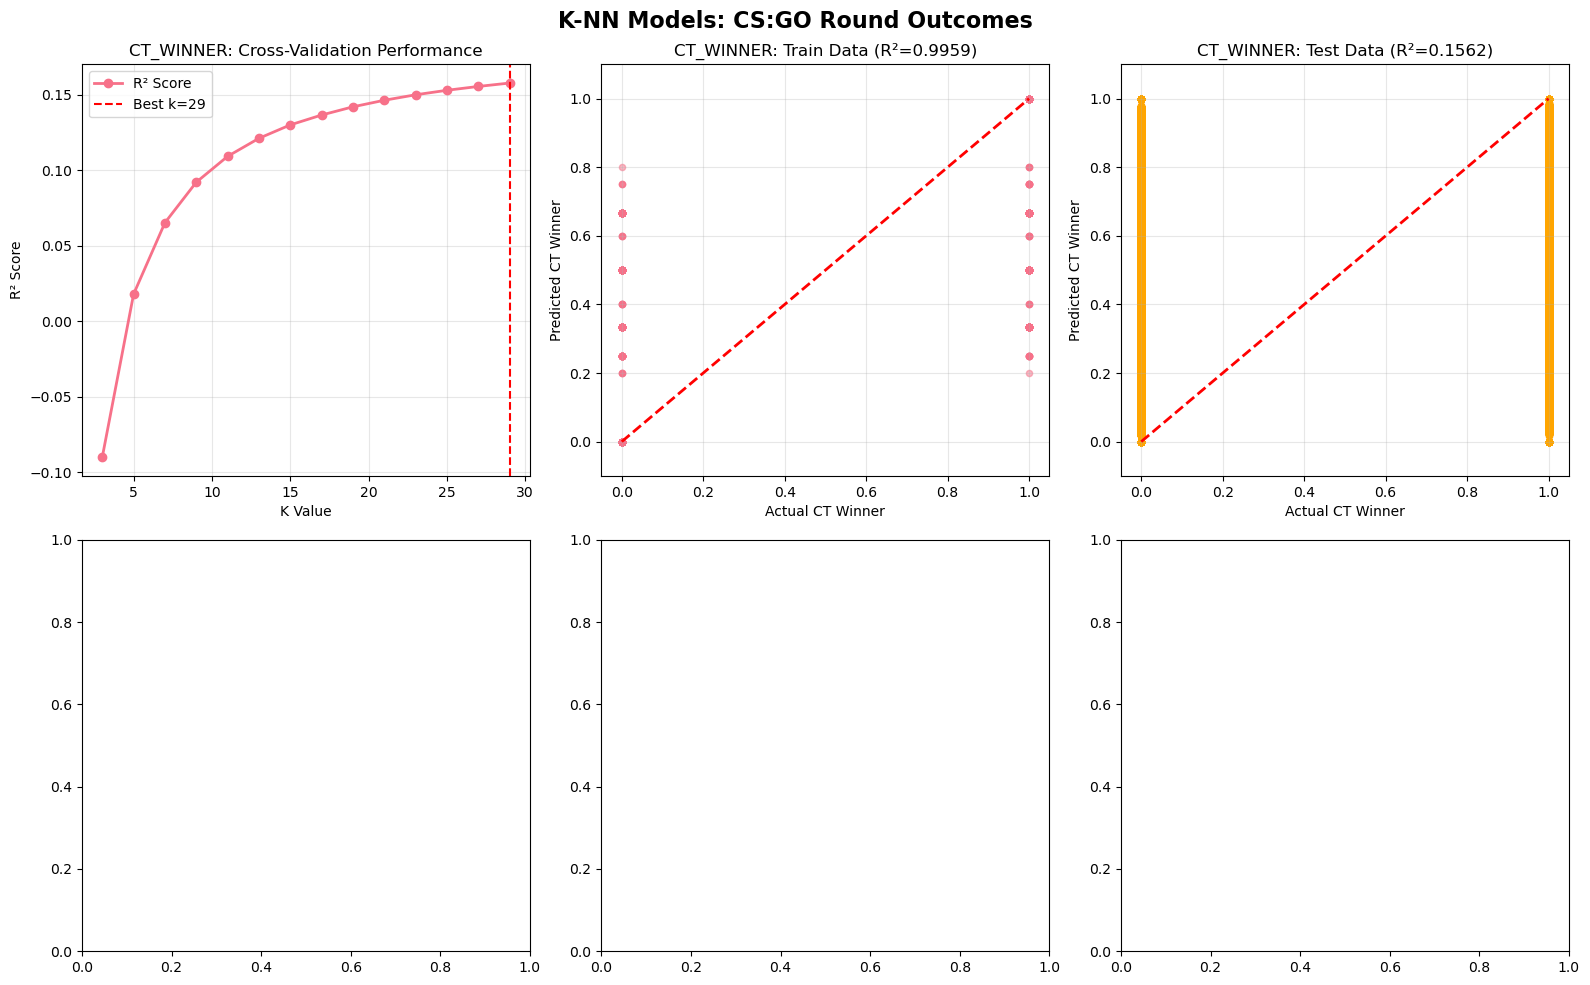

In [6]:
# ============================================================================
# K-NN REGRESSION & CLASSIFICATION MODELS
# ============================================================================

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("K-NN REGRESSION & CLASSIFICATION MODELS FOR CS:GO ROUND OUTCOMES")
print("="*80)
print()

# ============================================================================
# FEATURE ENGINEERING & SELECTION
# ============================================================================

# Define feature columns - select numeric and engineered features
feature_cols = [
    'ct_equipment',
    't_equipment',
    'ct_rank',
    't_rank',
]

# Additional engineered features
detailed_df['equipment_diff'] = detailed_df['ct_equipment'] - detailed_df['t_equipment']
detailed_df['rank_diff'] = detailed_df['ct_rank'] - detailed_df['t_rank']
detailed_df['ct_equipment_ratio'] = detailed_df['ct_equipment'] / (detailed_df['t_equipment'] + detailed_df['ct_equipment'])

feature_cols.extend([
    'equipment_diff',
    'rank_diff',
    'ct_equipment_ratio',
])

# Remove rows with missing values
df_clean = detailed_df[feature_cols + ['ct_winner']].dropna()
print(f"Clean dataset: {len(df_clean):,} rows")
print(f"   Features: {len(feature_cols)}")
print()

# ============================================================================
# MODEL 1: K-NN REGRESSION - CT_WINNER (Binary Outcome)
# ============================================================================

print("="*80)
print("MODEL 1: K-NN REGRESSION FOR CT_WINNER PREDICTION")
print("="*80)

X = df_clean[feature_cols]
y_winner = df_clean['ct_winner']

# Scale features (important for k-nn)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(
    X_scaled, y_winner, test_size=0.3, random_state=42, stratify=y_winner
)

print(f"\n Data Split:")
print(f"   Training: {len(X_train_w):,} samples")
print(f"   Testing: {len(X_test_w):,} samples")
print(f"   CT Win Rate: {y_winner.mean():.2%}")
print()

# Hyperparameter tuning via cross-validation
print("🔍 Hyperparameter Tuning (Finding optimal k)...")
k_values = list(range(3, 31, 2))
cv_scores_r2 = []
cv_scores_mae = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance', p=2)
    
    # Cross-validation with multiple metrics
    cv_results = cross_validate(
        knn, X_train_w, y_train_w, 
        cv=3,
        scoring=['r2', 'neg_mean_absolute_error']
    )
    
    r2_mean = cv_results['test_r2'].mean()
    mae_mean = -cv_results['test_neg_mean_absolute_error'].mean()
    cv_scores_r2.append(r2_mean)
    cv_scores_mae.append(mae_mean)

# Find best k
best_k_idx = np.argmax(cv_scores_r2)
best_k = k_values[best_k_idx]

print(f"   Best k: {best_k} (R² = {cv_scores_r2[best_k_idx]:.4f})")
print()

# Train final model
knn_winner = KNeighborsRegressor(n_neighbors=best_k, weights='distance', p=2)
knn_winner.fit(X_train_w, y_train_w)

# Predictions
y_pred_train_w = knn_winner.predict(X_train_w)
y_pred_test_w = knn_winner.predict(X_test_w)

# Evaluation - Regression Metrics
train_r2_w = r2_score(y_train_w, y_pred_train_w)
test_r2_w = r2_score(y_test_w, y_pred_test_w)
train_mae_w = mean_absolute_error(y_train_w, y_pred_train_w)
test_mae_w = mean_absolute_error(y_test_w, y_pred_test_w)
train_rmse_w = np.sqrt(mean_squared_error(y_train_w, y_pred_train_w))
test_rmse_w = np.sqrt(mean_squared_error(y_test_w, y_pred_test_w))

print("📈 CT_WINNER Model Performance:")
print(f"\n   Training Metrics:")
print(f"      R² Score: {train_r2_w:.4f}")
print(f"      MAE: {train_mae_w:.4f}")
print(f"      RMSE: {train_rmse_w:.4f}")

print(f"\n   Test Metrics:")
print(f"      R² Score: {test_r2_w:.4f}")
print(f"      MAE: {test_mae_w:.4f}")
print(f"      RMSE: {test_rmse_w:.4f}")
print()

# Classification metrics (convert predictions to binary)
y_pred_test_w_binary = (y_pred_test_w > 0.5).astype(int)
accuracy_w = accuracy_score(y_test_w, y_pred_test_w_binary)
print(f"   Classification Accuracy: {accuracy_w:.4f}")
print()


# ============================================================================
# VISUALIZATION: MODEL COMPARISON & PERFORMANCE
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('K-NN Models: CS:GO Round Outcomes', fontsize=16, fontweight='bold')

# Row 1: CT_WINNER Model (Regression)
# Plot 1: CV Scores vs K
axes[0, 0].plot(k_values, cv_scores_r2, marker='o', linewidth=2, markersize=6, label='R² Score')
axes[0, 0].axvline(best_k, color='red', linestyle='--', label=f'Best k={best_k}')
axes[0, 0].set_xlabel('K Value')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].set_title('CT_WINNER: Cross-Validation Performance')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Actual vs Predicted (Training)
axes[0, 1].scatter(y_train_w, y_pred_train_w, alpha=0.5, s=20)
axes[0, 1].plot([0, 1], [0, 1], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual CT Winner')
axes[0, 1].set_ylabel('Predicted CT Winner')
axes[0, 1].set_title(f'CT_WINNER: Train Data (R²={train_r2_w:.4f})')
axes[0, 1].set_ylim(-0.1, 1.1)
axes[0, 1].grid(alpha=0.3)

# Plot 3: Actual vs Predicted (Test)
axes[0, 2].scatter(y_test_w, y_pred_test_w, alpha=0.5, s=20, color='orange')
axes[0, 2].plot([0, 1], [0, 1], 'r--', lw=2)
axes[0, 2].set_xlabel('Actual CT Winner')
axes[0, 2].set_ylabel('Predicted CT Winner')
axes[0, 2].set_title(f'CT_WINNER: Test Data (R²={test_r2_w:.4f})')
axes[0, 2].set_ylim(-0.1, 1.1)
axes[0, 2].grid(alpha=0.3)


plt.tight_layout()
plt.show()




# Feature Engineering: Log Rank Difference
Creating log-transformed rank difference to model CT winner prediction


LOG RANK DIFFERENCE ANALYSIS FOR CT_WINNER PREDICTION (K-NN)

✅ Created log_diff_rank feature
   Total samples: 1,821,152
   CT Win Rate: 51.63%

MODEL 1: CT_WINNER ~ log_diff_rank (Rank Only - K-NN)

📦 Data Split:
   Training: 1,274,806 samples
   Testing: 546,346 samples

🔍 Hyperparameter Tuning (Finding optimal k)...
   Best k: 29 (CV AUC = 0.5391)

📈 Rank-Only K-NN Model Performance:

   Training Metrics:
      Accuracy: 0.5532
      AUC-ROC: 0.5777

   Test Metrics:
      Accuracy: 0.5316
      AUC-ROC: 0.5450

MODEL 2: CT_WINNER ~ log_diff_rank + Equipment (Rank + Equipment - K-NN)

📦 Data Split:
   Training: 1,274,806 samples
   Testing: 546,346 samples

🔍 Hyperparameter Tuning (Finding optimal k for extended features)...
   Best k: 49 (CV AUC = 0.7281)

📈 Extended K-NN Model Performance:

   Training Metrics:
      Accuracy: 0.9961
      AUC-ROC: 1.0000

   Test Metrics:
      Accuracy: 0.6472
      AUC-ROC: 0.7205

K-NN MODEL COMPARISON

                  Model  Best K  Train 

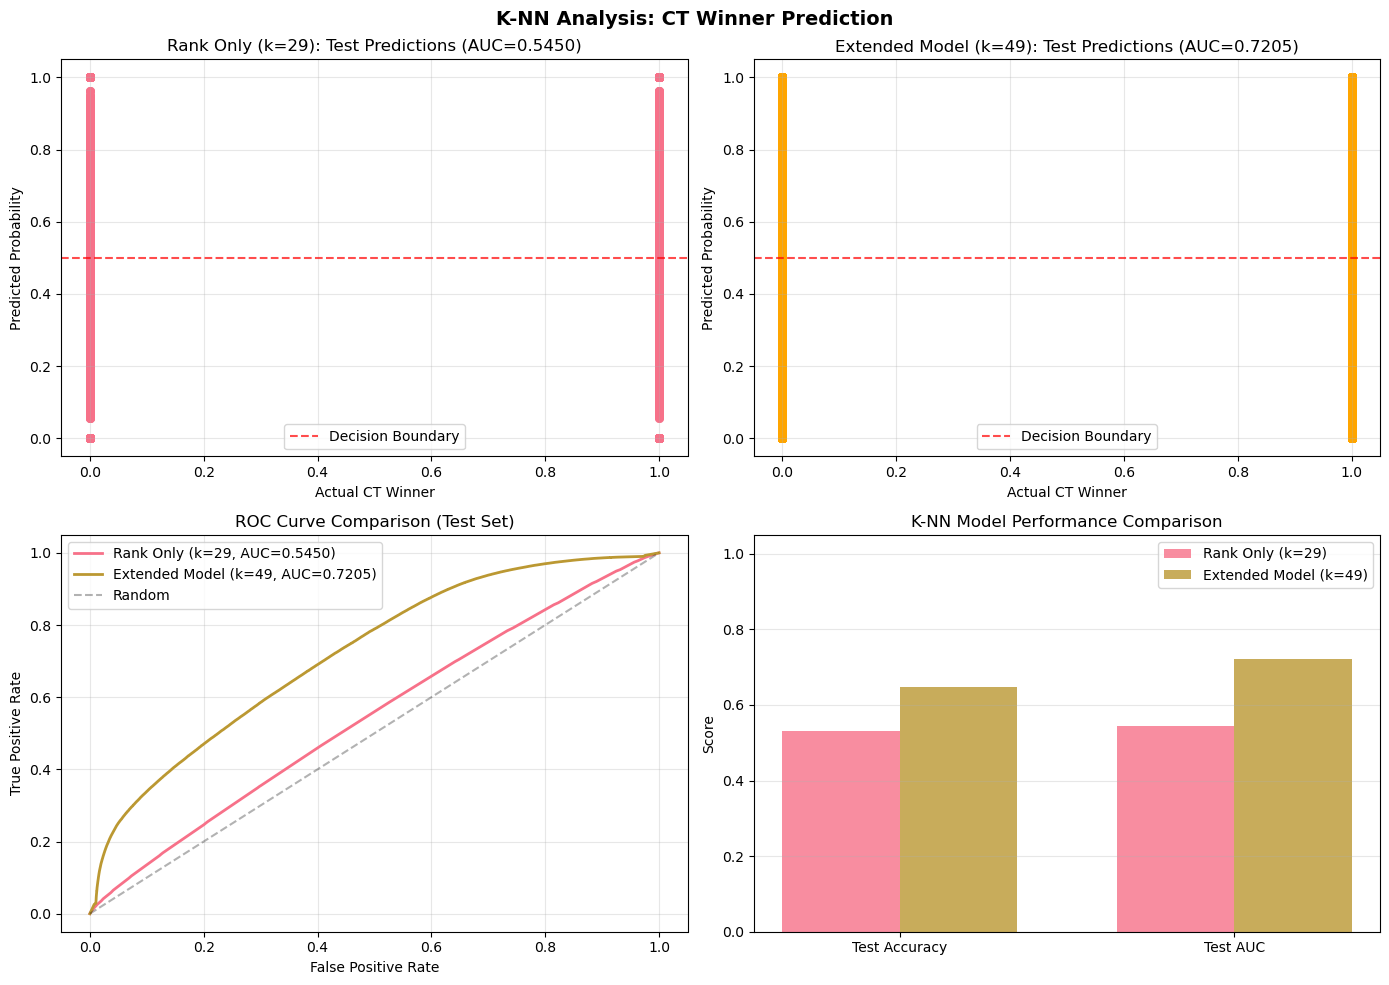

✅ K-NN Analysis Complete!


In [7]:
# ============================================================================
# LOG RANK DIFFERENCE ANALYSIS WITH K-NN CLASSIFICATION
# ============================================================================

from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

print("="*80)
print("LOG RANK DIFFERENCE ANALYSIS FOR CT_WINNER PREDICTION (K-NN)")
print("="*80)
print()

# Create log-transformed rank difference
df_rank_analysis = detailed_df[['ct_rank', 't_rank', 'ct_winner', 'ct_equipment', 't_equipment']].dropna()

# Create log_diff_rank feature
df_rank_analysis['log_diff_rank'] = np.log(df_rank_analysis['ct_rank']) - np.log(df_rank_analysis['t_rank'])

print(f"✅ Created log_diff_rank feature")
print(f"   Total samples: {len(df_rank_analysis):,}")
print(f"   CT Win Rate: {df_rank_analysis['ct_winner'].mean():.2%}")
print()

# Prepare data for scaling
scaler_rank = StandardScaler()

# ============================================================================
# MODEL 1: CT_WINNER ~ log_diff_rank (RANK ONLY - K-NN)
# ============================================================================

print("="*80)
print("MODEL 1: CT_WINNER ~ log_diff_rank (Rank Only - K-NN)")
print("="*80)
print()

X_rank_only = df_rank_analysis[['log_diff_rank']].values
X_rank_scaled = scaler_rank.fit_transform(X_rank_only)
y_target = df_rank_analysis['ct_winner'].values

# Split data
X_train_ro, X_test_ro, y_train_ro, y_test_ro = train_test_split(
    X_rank_scaled, y_target, test_size=0.3, random_state=42, stratify=y_target
)

print(f"📦 Data Split:")
print(f"   Training: {len(X_train_ro):,} samples")
print(f"   Testing: {len(X_test_ro):,} samples")
print()

# Hyperparameter tuning for K-NN
print("🔍 Hyperparameter Tuning (Finding optimal k)...")
param_grid = {'n_neighbors': range(3, 31, 2)}
knn_ro = KNeighborsClassifier()
grid_search_ro = GridSearchCV(knn_ro, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_ro.fit(X_train_ro, y_train_ro)

best_k_ro = grid_search_ro.best_params_['n_neighbors']
best_auc_ro = grid_search_ro.best_score_

print(f"   Best k: {best_k_ro} (CV AUC = {best_auc_ro:.4f})")
print()

# Train final model with best k
knn_ro = KNeighborsClassifier(n_neighbors=best_k_ro, weights='distance', p=2)
knn_ro.fit(X_train_ro, y_train_ro)

# Predictions
y_pred_train_ro = knn_ro.predict(X_train_ro)
y_pred_test_ro = knn_ro.predict(X_test_ro)
y_pred_proba_train_ro = knn_ro.predict_proba(X_train_ro)[:, 1]
y_pred_proba_test_ro = knn_ro.predict_proba(X_test_ro)[:, 1]

# Evaluation
train_acc_ro = accuracy_score(y_train_ro, y_pred_train_ro)
test_acc_ro = accuracy_score(y_test_ro, y_pred_test_ro)
train_auc_ro = roc_auc_score(y_train_ro, y_pred_proba_train_ro)
test_auc_ro = roc_auc_score(y_test_ro, y_pred_proba_test_ro)

print("📈 Rank-Only K-NN Model Performance:")
print(f"\n   Training Metrics:")
print(f"      Accuracy: {train_acc_ro:.4f}")
print(f"      AUC-ROC: {train_auc_ro:.4f}")

print(f"\n   Test Metrics:")
print(f"      Accuracy: {test_acc_ro:.4f}")
print(f"      AUC-ROC: {test_auc_ro:.4f}")
print()

# ============================================================================
# MODEL 2: CT_WINNER ~ log_diff_rank + ct_equipment + t_equipment (K-NN)
# ============================================================================

print("="*80)
print("MODEL 2: CT_WINNER ~ log_diff_rank + Equipment (Rank + Equipment - K-NN)")
print("="*80)
print()

df_rank_analysis['ct_eq_ratio'] = df_rank_analysis['ct_equipment'] / (df_rank_analysis['t_equipment'] + df_rank_analysis['ct_equipment'])
df_rank_analysis['log_eq'] = np.log(df_rank_analysis['ct_equipment'] + 1) - np.log(df_rank_analysis['t_equipment'] + 1)

# Create feature set with rank and equipment
X_rank_equip = df_rank_analysis[['log_diff_rank', 'ct_equipment', 't_equipment', 'ct_eq_ratio', 'log_eq']].values
scaler_rank_equip = StandardScaler()
X_rank_equip_scaled = scaler_rank_equip.fit_transform(X_rank_equip)

# Split data (use same random seed for comparison)
X_train_re, X_test_re, y_train_re, y_test_re = train_test_split(
    X_rank_equip_scaled, y_target, test_size=0.3, random_state=42, stratify=y_target
)

print(f"📦 Data Split:")
print(f"   Training: {len(X_train_re):,} samples")
print(f"   Testing: {len(X_test_re):,} samples")
print()

# Hyperparameter tuning for K-NN with extended features
print("🔍 Hyperparameter Tuning (Finding optimal k for extended features)...")
param_grid_re = {'n_neighbors': range(3, 51, 2)}
knn_re = KNeighborsClassifier()
grid_search_re = GridSearchCV(knn_re, param_grid_re, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_re.fit(X_train_re, y_train_re)

best_k_re = grid_search_re.best_params_['n_neighbors']
best_auc_re = grid_search_re.best_score_

print(f"   Best k: {best_k_re} (CV AUC = {best_auc_re:.4f})")
print()

# Train final model with best k
knn_re = KNeighborsClassifier(n_neighbors=best_k_re, weights='distance', p=2)
knn_re.fit(X_train_re, y_train_re)

# Predictions
y_pred_train_re = knn_re.predict(X_train_re)
y_pred_test_re = knn_re.predict(X_test_re)
y_pred_proba_train_re = knn_re.predict_proba(X_train_re)[:, 1]
y_pred_proba_test_re = knn_re.predict_proba(X_test_re)[:, 1]

# Evaluation
train_acc_re = accuracy_score(y_train_re, y_pred_train_re)
test_acc_re = accuracy_score(y_test_re, y_pred_test_re)
train_auc_re = roc_auc_score(y_train_re, y_pred_proba_train_re)
test_auc_re = roc_auc_score(y_test_re, y_pred_proba_test_re)

print("📈 Extended K-NN Model Performance:")
print(f"\n   Training Metrics:")
print(f"      Accuracy: {train_acc_re:.4f}")
print(f"      AUC-ROC: {train_auc_re:.4f}")

print(f"\n   Test Metrics:")
print(f"      Accuracy: {test_acc_re:.4f}")
print(f"      AUC-ROC: {test_auc_re:.4f}")
print()

# ============================================================================
# MODEL COMPARISON & VISUALIZATION
# ============================================================================

print("="*80)
print("K-NN MODEL COMPARISON")
print("="*80)
print()

comparison_data = {
    'Model': ['Rank Only (K-NN)', 'Rank + Equipment (K-NN)'],
    'Best K': [best_k_ro, best_k_re],
    'Train Accuracy': [train_acc_ro, train_acc_re],
    'Test Accuracy': [test_acc_ro, test_acc_re],
    'Train AUC': [train_auc_ro, train_auc_re],
    'Test AUC': [test_auc_ro, test_auc_re],
    'Improvement (Acc)': [0, test_acc_re - test_acc_ro],
    'Improvement (AUC)': [0, test_auc_re - test_auc_ro]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))
print()

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('K-NN Analysis: CT Winner Prediction', fontsize=14, fontweight='bold')

# Plot 1: Predicted probabilities (Rank Only) - Test Set
axes[0, 0].scatter(y_test_ro, y_pred_proba_test_ro, alpha=0.5, s=30)
axes[0, 0].axhline(0.5, color='red', linestyle='--', alpha=0.7, label='Decision Boundary')
axes[0, 0].set_xlabel('Actual CT Winner')
axes[0, 0].set_ylabel('Predicted Probability')
axes[0, 0].set_title(f'Rank Only (k={best_k_ro}): Test Predictions (AUC={test_auc_ro:.4f})')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Predicted probabilities (Rank + Equipment + Ratios) - Test Set
axes[0, 1].scatter(y_test_re, y_pred_proba_test_re, alpha=0.5, s=30, color='orange')
axes[0, 1].axhline(0.5, color='red', linestyle='--', alpha=0.7, label='Decision Boundary')
axes[0, 1].set_xlabel('Actual CT Winner')
axes[0, 1].set_ylabel('Predicted Probability')
axes[0, 1].set_title(f'Extended Model (k={best_k_re}): Test Predictions (AUC={test_auc_re:.4f})')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 3: ROC Curves Comparison
fpr_ro, tpr_ro, _ = roc_curve(y_test_ro, y_pred_proba_test_ro)
fpr_re, tpr_re, _ = roc_curve(y_test_re, y_pred_proba_test_re)

axes[1, 0].plot(fpr_ro, tpr_ro, label=f'Rank Only (k={best_k_ro}, AUC={test_auc_ro:.4f})', linewidth=2)
axes[1, 0].plot(fpr_re, tpr_re, label=f'Extended Model (k={best_k_re}, AUC={test_auc_re:.4f})', linewidth=2)
axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC Curve Comparison (Test Set)')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 4: Model Metrics Comparison
metrics = ['Test Accuracy', 'Test AUC']
rank_only_scores = [test_acc_ro, test_auc_ro]
extended_scores = [test_acc_re, test_auc_re]

x_pos = np.arange(len(metrics))
width = 0.35

axes[1, 1].bar(x_pos - width/2, rank_only_scores, width, label=f'Rank Only (k={best_k_ro})', alpha=0.8)
axes[1, 1].bar(x_pos + width/2, extended_scores, width, label=f'Extended Model (k={best_k_re})', alpha=0.8)
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('K-NN Model Performance Comparison')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(metrics)
axes[1, 1].legend()
axes[1, 1].set_ylim([0, 1.05])
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✅ K-NN Analysis Complete!")


SEMI-PARAMETRIC APPROACH: GENERALIZED ADDITIVE MODELS (GAM)

✅ Prepared GAM dataset
   Total samples: 2,598,771
   CT Win Rate: 51.54%

MODEL 1: GAM SEMI-PARAMETRIC - CT_WINNER ~ s(equipment_diff)

📊 Outlier Filtering (95% Quantile):
   95% Quantile threshold: 24950.00
   Samples removed: 129,534
   Samples retained: 2,469,237

📈 Model 1 Summary (equipment_diff):
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     23.2737
Link Function:                        LogitLink Log Likelihood:                              -1492402.1318
Number of Samples:                      2469237 AIC:                                           2984850.811
                                                AICc:                                         29848

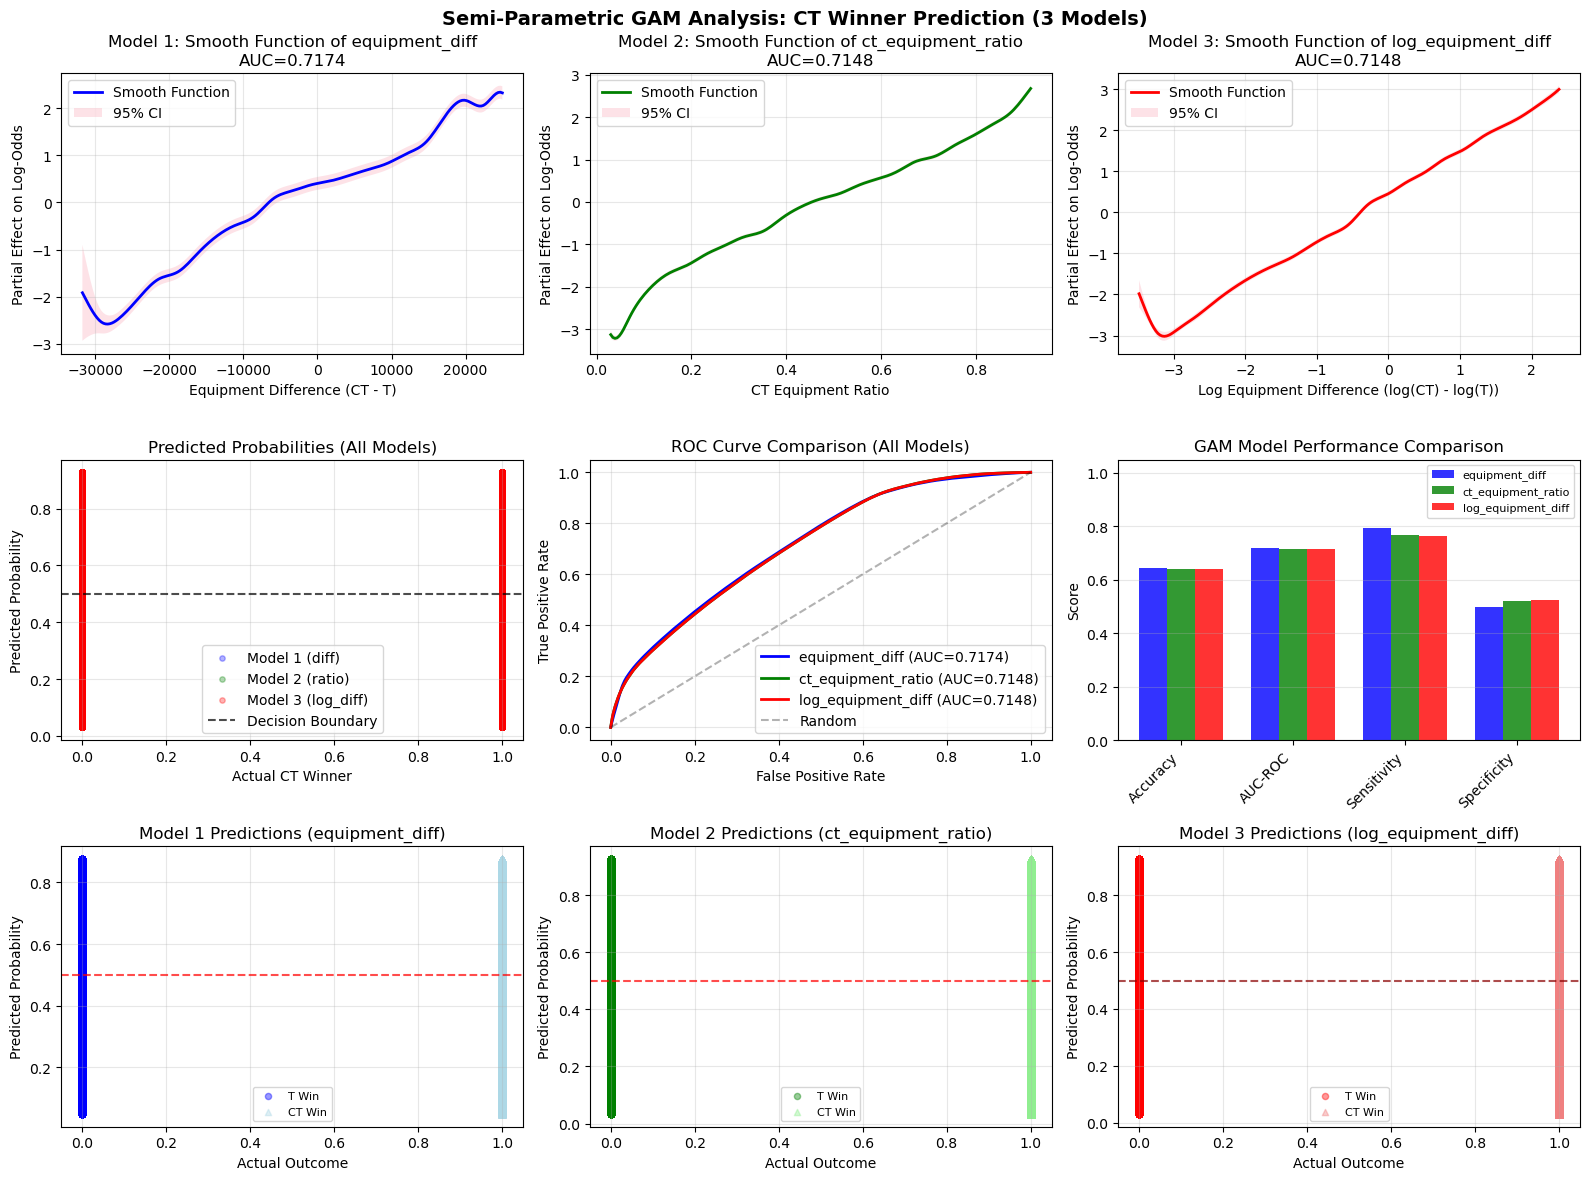

✅ Semi-Parametric GAM Analysis Complete!


In [13]:
# ============================================================================
# SEMI-PARAMETRIC APPROACH: GENERALIZED ADDITIVE MODELS (GAM)
# ============================================================================

# Install pygam if not already installed
try:
    from pygam import LogisticGAM, s
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'pygam'])
    from pygam import LogisticGAM, s

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix

print("="*80)
print("SEMI-PARAMETRIC APPROACH: GENERALIZED ADDITIVE MODELS (GAM)")
print("="*80)
print()

# Prepare data for GAM analysis
df_gam = detailed_df[['ct_winner', 'ct_equipment', 't_equipment']].dropna()

# Create engineered features
df_gam['equipment_diff'] = df_gam['ct_equipment'] - df_gam['t_equipment']
df_gam['ct_equipment_ratio'] = df_gam['ct_equipment'] / (df_gam['t_equipment'] + df_gam['ct_equipment'])

print(f"✅ Prepared GAM dataset")
print(f"   Total samples: {len(df_gam):,}")
print(f"   CT Win Rate: {df_gam['ct_winner'].mean():.2%}")
print()

# ============================================================================
# MODEL 1: GAM SEMI-PARAMETRIC - CT_WINNER ~ s(equipment_diff)
# ============================================================================

print("="*80)
print("MODEL 1: GAM SEMI-PARAMETRIC - CT_WINNER ~ s(equipment_diff)")
print("="*80)
print()

X_diff = df_gam[['equipment_diff']].values
y_gam = df_gam['ct_winner'].values

# Exclude outliers at 95% quantile for equipment_diff
q95_diff = np.quantile(X_diff, 0.95)
mask_diff = X_diff[:, 0] <= q95_diff
X_diff_filtered = X_diff[mask_diff]
y_gam_filtered = y_gam[mask_diff]

print(f"📊 Outlier Filtering (95% Quantile):")
print(f"   95% Quantile threshold: {q95_diff:.2f}")
print(f"   Samples removed: {len(X_diff) - len(X_diff_filtered):,}")
print(f"   Samples retained: {len(X_diff_filtered):,}")
print()

# Fit Logistic GAM with smooth term for equipment_diff
gam_model_1 = LogisticGAM(s(0, n_splines=25))
gam_model_1.fit(X_diff_filtered, y_gam_filtered)

print("📈 Model 1 Summary (equipment_diff):")
print(gam_model_1.summary())
print()

# Predictions and evaluation
y_pred_proba_gam1 = gam_model_1.predict_proba(X_diff_filtered)
y_pred_binary_gam1 = gam_model_1.predict(X_diff_filtered)

acc_gam1 = accuracy_score(y_gam_filtered, y_pred_binary_gam1)
auc_gam1 = roc_auc_score(y_gam_filtered, y_pred_proba_gam1)
cm_gam1 = confusion_matrix(y_gam_filtered, y_pred_binary_gam1)

print("📊 Model 1 Performance Metrics:")
print(f"   Accuracy: {acc_gam1:.4f}")
print(f"   AUC-ROC: {auc_gam1:.4f}")
print()
print(f"   Confusion Matrix:")
print(f"      True Negatives:  {cm_gam1[0, 0]:,}")
print(f"      False Positives: {cm_gam1[0, 1]:,}")
print(f"      False Negatives: {cm_gam1[1, 0]:,}")
print(f"      True Positives:  {cm_gam1[1, 1]:,}")
print()
print(f"   Sensitivity (Recall): {cm_gam1[1, 1] / (cm_gam1[1, 0] + cm_gam1[1, 1]):.4f}")
print(f"   Specificity: {cm_gam1[0, 0] / (cm_gam1[0, 0] + cm_gam1[0, 1]):.4f}")
print()

# Get predictions for plotting
X_diff_min, X_diff_max = X_diff_filtered.min(), X_diff_filtered.max()
X_diff_grid = np.linspace(X_diff_min, X_diff_max, 200).reshape(-1, 1)
pdep_diff, confi_diff = gam_model_1.partial_dependence(0, X=X_diff_grid, width=0.95)

# ============================================================================
# MODEL 2: GAM SEMI-PARAMETRIC - CT_WINNER ~ s(ct_equipment_ratio)
# ============================================================================

print("="*80)
print("MODEL 2: GAM SEMI-PARAMETRIC - CT_WINNER ~ s(ct_equipment_ratio)")
print("="*80)
print()

X_ratio = df_gam[['ct_equipment_ratio']].values
y_gam = df_gam['ct_winner'].values

# Exclude outliers at 95% quantile for ct_equipment_ratio
q95_ratio = np.quantile(X_ratio, 0.95)
mask_ratio = X_ratio[:, 0] <= q95_ratio
X_ratio_filtered = X_ratio[mask_ratio]
y_gam_ratio_filtered = y_gam[mask_ratio]

print(f"📊 Outlier Filtering (95% Quantile):")
print(f"   95% Quantile threshold: {q95_ratio:.4f}")
print(f"   Samples removed: {len(X_ratio) - len(X_ratio_filtered):,}")
print(f"   Samples retained: {len(X_ratio_filtered):,}")
print()

# Fit Logistic GAM with smooth term for ct_equipment_ratio
gam_model_2 = LogisticGAM(s(0, n_splines=25))
gam_model_2.fit(X_ratio_filtered, y_gam_ratio_filtered)

print("📈 Model 2 Summary (ct_equipment_ratio):")
print(gam_model_2.summary())
print()

# Predictions and evaluation
y_pred_proba_gam2 = gam_model_2.predict_proba(X_ratio_filtered)
y_pred_binary_gam2 = gam_model_2.predict(X_ratio_filtered)

acc_gam2 = accuracy_score(y_gam_ratio_filtered, y_pred_binary_gam2)
auc_gam2 = roc_auc_score(y_gam_ratio_filtered, y_pred_proba_gam2)
cm_gam2 = confusion_matrix(y_gam_ratio_filtered, y_pred_binary_gam2)

print("📊 Model 2 Performance Metrics:")
print(f"   Accuracy: {acc_gam2:.4f}")
print(f"   AUC-ROC: {auc_gam2:.4f}")
print()
print(f"   Confusion Matrix:")
print(f"      True Negatives:  {cm_gam2[0, 0]:,}")
print(f"      False Positives: {cm_gam2[0, 1]:,}")
print(f"      False Negatives: {cm_gam2[1, 0]:,}")
print(f"      True Positives:  {cm_gam2[1, 1]:,}")
print()
print(f"   Sensitivity (Recall): {cm_gam2[1, 1] / (cm_gam2[1, 0] + cm_gam2[1, 1]):.4f}")
print(f"   Specificity: {cm_gam2[0, 0] / (cm_gam2[0, 0] + cm_gam2[0, 1]):.4f}")
print()

# Get predictions for plotting
X_ratio_min, X_ratio_max = X_ratio_filtered.min(), X_ratio_filtered.max()
X_ratio_grid = np.linspace(X_ratio_min, X_ratio_max, 200).reshape(-1, 1)
pdep_ratio, confi_ratio = gam_model_2.partial_dependence(0, X=X_ratio_grid, width=0.95)

# ============================================================================
# MODEL 3: GAM SEMI-PARAMETRIC - CT_WINNER ~ s(log_equipment_diff)
# ============================================================================

print("="*80)
print("MODEL 3: GAM SEMI-PARAMETRIC - CT_WINNER ~ s(log_equipment_diff)")
print("="*80)
print()

# Create log-transformed equipment difference
df_gam['log_equipment_diff'] = np.log(df_gam['ct_equipment'] + 1) - np.log(df_gam['t_equipment'] + 1)

X_log_diff = df_gam[['log_equipment_diff']].values
y_gam = df_gam['ct_winner'].values

# Exclude outliers at 95% quantile for log_equipment_diff
q95_log_diff = np.quantile(X_log_diff, 0.95)
mask_log_diff = X_log_diff[:, 0] <= q95_log_diff
X_log_diff_filtered = X_log_diff[mask_log_diff]
y_gam_log_diff_filtered = y_gam[mask_log_diff]

print(f"📊 Outlier Filtering (95% Quantile):")
print(f"   95% Quantile threshold: {q95_log_diff:.4f}")
print(f"   Samples removed: {len(X_log_diff) - len(X_log_diff_filtered):,}")
print(f"   Samples retained: {len(X_log_diff_filtered):,}")
print()

# Fit Logistic GAM with smooth term for log_equipment_diff
gam_model_3 = LogisticGAM(s(0, n_splines=25))
gam_model_3.fit(X_log_diff_filtered, y_gam_log_diff_filtered)

print("📈 Model 3 Summary (log_equipment_diff):")
print(gam_model_3.summary())
print()

# Predictions and evaluation
y_pred_proba_gam3 = gam_model_3.predict_proba(X_log_diff_filtered)
y_pred_binary_gam3 = gam_model_3.predict(X_log_diff_filtered)

acc_gam3 = accuracy_score(y_gam_log_diff_filtered, y_pred_binary_gam3)
auc_gam3 = roc_auc_score(y_gam_log_diff_filtered, y_pred_proba_gam3)
cm_gam3 = confusion_matrix(y_gam_log_diff_filtered, y_pred_binary_gam3)

print("📊 Model 3 Performance Metrics:")
print(f"   Accuracy: {acc_gam3:.4f}")
print(f"   AUC-ROC: {auc_gam3:.4f}")
print()
print(f"   Confusion Matrix:")
print(f"      True Negatives:  {cm_gam3[0, 0]:,}")
print(f"      False Positives: {cm_gam3[0, 1]:,}")
print(f"      False Negatives: {cm_gam3[1, 0]:,}")
print(f"      True Positives:  {cm_gam3[1, 1]:,}")
print()
print(f"   Sensitivity (Recall): {cm_gam3[1, 1] / (cm_gam3[1, 0] + cm_gam3[1, 1]):.4f}")
print(f"   Specificity: {cm_gam3[0, 0] / (cm_gam3[0, 0] + cm_gam3[0, 1]):.4f}")
print()

# Get predictions for plotting
X_log_diff_min, X_log_diff_max = X_log_diff_filtered.min(), X_log_diff_filtered.max()
X_log_diff_grid = np.linspace(X_log_diff_min, X_log_diff_max, 200).reshape(-1, 1)
pdep_log_diff, confi_log_diff = gam_model_3.partial_dependence(0, X=X_log_diff_grid, width=0.95)

# ============================================================================
# MODEL COMPARISON
# ============================================================================

print("="*80)
print("GAM SEMI-PARAMETRIC MODEL COMPARISON")
print("="*80)
print()

gam_comparison_data = {
    'Model': ['equipment_diff', 'ct_equipment_ratio', 'log_equipment_diff'],
    'Accuracy': [acc_gam1, acc_gam2, acc_gam3],
    'AUC-ROC': [auc_gam1, auc_gam2, auc_gam3],
    'Sensitivity': [cm_gam1[1, 1] / (cm_gam1[1, 0] + cm_gam1[1, 1]),
                    cm_gam2[1, 1] / (cm_gam2[1, 0] + cm_gam2[1, 1]),
                    cm_gam3[1, 1] / (cm_gam3[1, 0] + cm_gam3[1, 1])],
    'Specificity': [cm_gam1[0, 0] / (cm_gam1[0, 0] + cm_gam1[0, 1]),
                    cm_gam2[0, 0] / (cm_gam2[0, 0] + cm_gam2[0, 1]),
                    cm_gam3[0, 0] / (cm_gam3[0, 0] + cm_gam3[0, 1])],
    'AIC': [gam_model_1.statistics_['AIC'], gam_model_2.statistics_['AIC'], gam_model_3.statistics_['AIC']],
    'GCV Score': [gam_model_1.statistics_['GCV'], gam_model_2.statistics_['GCV'], gam_model_3.statistics_['GCV']]
}

gam_comparison_df = pd.DataFrame(gam_comparison_data)
print(gam_comparison_df.to_string(index=False))
print()

# ============================================================================
# VISUALIZATION: GAM SMOOTH FUNCTIONS & ROC CURVES
# ============================================================================

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
fig.suptitle('Semi-Parametric GAM Analysis: CT Winner Prediction (3 Models)', fontsize=14, fontweight='bold')

# Plot 1: Model 1 - Partial Dependence (equipment_diff)
axes[0, 0].plot(X_diff_grid, pdep_diff, 'b-', linewidth=2, label='Smooth Function')
axes[0, 0].fill_between(X_diff_grid[:, 0], confi_diff[:, 0], confi_diff[:, 1], alpha=0.2, label='95% CI')
axes[0, 0].set_xlabel('Equipment Difference (CT - T)')
axes[0, 0].set_ylabel('Partial Effect on Log-Odds')
axes[0, 0].set_title(f'Model 1: Smooth Function of equipment_diff\nAUC={auc_gam1:.4f}')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Model 2 - Partial Dependence (ct_equipment_ratio)
axes[0, 1].plot(X_ratio_grid, pdep_ratio, 'g-', linewidth=2, label='Smooth Function')
axes[0, 1].fill_between(X_ratio_grid[:, 0], confi_ratio[:, 0], confi_ratio[:, 1], alpha=0.2, label='95% CI')
axes[0, 1].set_xlabel('CT Equipment Ratio')
axes[0, 1].set_ylabel('Partial Effect on Log-Odds')
axes[0, 1].set_title(f'Model 2: Smooth Function of ct_equipment_ratio\nAUC={auc_gam2:.4f}')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 3: Model 3 - Partial Dependence (log_equipment_diff)
axes[0, 2].plot(X_log_diff_grid, pdep_log_diff, 'r-', linewidth=2, label='Smooth Function')
axes[0, 2].fill_between(X_log_diff_grid[:, 0], confi_log_diff[:, 0], confi_log_diff[:, 1], alpha=0.2, label='95% CI')
axes[0, 2].set_xlabel('Log Equipment Difference (log(CT) - log(T))')
axes[0, 2].set_ylabel('Partial Effect on Log-Odds')
axes[0, 2].set_title(f'Model 3: Smooth Function of log_equipment_diff\nAUC={auc_gam3:.4f}')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# Plot 4: Model Predictions Comparison (All Models)
axes[1, 0].scatter(y_gam_filtered, y_pred_proba_gam1, alpha=0.3, s=15, label='Model 1 (diff)', color='blue')
axes[1, 0].scatter(y_gam_ratio_filtered, y_pred_proba_gam2, alpha=0.3, s=15, label='Model 2 (ratio)', color='green')
axes[1, 0].scatter(y_gam_log_diff_filtered, y_pred_proba_gam3, alpha=0.3, s=15, label='Model 3 (log_diff)', color='red')
axes[1, 0].axhline(0.5, color='black', linestyle='--', alpha=0.7, label='Decision Boundary')
axes[1, 0].set_xlabel('Actual CT Winner')
axes[1, 0].set_ylabel('Predicted Probability')
axes[1, 0].set_title('Predicted Probabilities (All Models)')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 5: ROC Curves Comparison (All Models)
fpr_gam1, tpr_gam1, _ = roc_curve(y_gam_filtered, y_pred_proba_gam1)
fpr_gam2, tpr_gam2, _ = roc_curve(y_gam_ratio_filtered, y_pred_proba_gam2)
fpr_gam3, tpr_gam3, _ = roc_curve(y_gam_log_diff_filtered, y_pred_proba_gam3)

axes[1, 1].plot(fpr_gam1, tpr_gam1, 'b-', label=f'equipment_diff (AUC={auc_gam1:.4f})', linewidth=2)
axes[1, 1].plot(fpr_gam2, tpr_gam2, 'g-', label=f'ct_equipment_ratio (AUC={auc_gam2:.4f})', linewidth=2)
axes[1, 1].plot(fpr_gam3, tpr_gam3, 'r-', label=f'log_equipment_diff (AUC={auc_gam3:.4f})', linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curve Comparison (All Models)')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# Plot 6: Model Performance Metrics (All Models)
metrics_names = ['Accuracy', 'AUC-ROC', 'Sensitivity', 'Specificity']
model_1_metrics = [acc_gam1, auc_gam1, 
                   cm_gam1[1, 1] / (cm_gam1[1, 0] + cm_gam1[1, 1]),
                   cm_gam1[0, 0] / (cm_gam1[0, 0] + cm_gam1[0, 1])]
model_2_metrics = [acc_gam2, auc_gam2, 
                   cm_gam2[1, 1] / (cm_gam2[1, 0] + cm_gam2[1, 1]),
                   cm_gam2[0, 0] / (cm_gam2[0, 0] + cm_gam2[0, 1])]
model_3_metrics = [acc_gam3, auc_gam3, 
                   cm_gam3[1, 1] / (cm_gam3[1, 0] + cm_gam3[1, 1]),
                   cm_gam3[0, 0] / (cm_gam3[0, 0] + cm_gam3[0, 1])]

x_pos = np.arange(len(metrics_names))
width = 0.25

axes[1, 2].bar(x_pos - width, model_1_metrics, width, label='equipment_diff', alpha=0.8, color='blue')
axes[1, 2].bar(x_pos, model_2_metrics, width, label='ct_equipment_ratio', alpha=0.8, color='green')
axes[1, 2].bar(x_pos + width, model_3_metrics, width, label='log_equipment_diff', alpha=0.8, color='red')
axes[1, 2].set_ylabel('Score')
axes[1, 2].set_title('GAM Model Performance Comparison')
axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(metrics_names, rotation=45, ha='right')
axes[1, 2].legend(fontsize=8)
axes[1, 2].set_ylim([0, 1.05])
axes[1, 2].grid(alpha=0.3, axis='y')

# Plot 7: Predicted vs Actual Scatter - Model 1
axes[2, 0].scatter(y_gam_filtered[y_gam_filtered == 0], y_pred_proba_gam1[y_gam_filtered == 0], alpha=0.4, s=20, 
                   label='T Win', color='blue', marker='o')
axes[2, 0].scatter(y_gam_filtered[y_gam_filtered == 1], y_pred_proba_gam1[y_gam_filtered == 1], alpha=0.4, s=20, 
                   label='CT Win', color='lightblue', marker='^')
axes[2, 0].axhline(0.5, color='red', linestyle='--', alpha=0.7)
axes[2, 0].set_xlabel('Actual Outcome')
axes[2, 0].set_ylabel('Predicted Probability')
axes[2, 0].set_title(f'Model 1 Predictions (equipment_diff)')
axes[2, 0].legend(fontsize=8)
axes[2, 0].grid(alpha=0.3)

# Plot 8: Predicted vs Actual Scatter - Model 2
axes[2, 1].scatter(y_gam_ratio_filtered[y_gam_ratio_filtered == 0], y_pred_proba_gam2[y_gam_ratio_filtered == 0], alpha=0.4, s=20, 
                   label='T Win', color='green', marker='o')
axes[2, 1].scatter(y_gam_ratio_filtered[y_gam_ratio_filtered == 1], y_pred_proba_gam2[y_gam_ratio_filtered == 1], alpha=0.4, s=20, 
                   label='CT Win', color='lightgreen', marker='^')
axes[2, 1].axhline(0.5, color='red', linestyle='--', alpha=0.7)
axes[2, 1].set_xlabel('Actual Outcome')
axes[2, 1].set_ylabel('Predicted Probability')
axes[2, 1].set_title(f'Model 2 Predictions (ct_equipment_ratio)')
axes[2, 1].legend(fontsize=8)
axes[2, 1].grid(alpha=0.3)

# Plot 9: Predicted vs Actual Scatter - Model 3
axes[2, 2].scatter(y_gam_log_diff_filtered[y_gam_log_diff_filtered == 0], y_pred_proba_gam3[y_gam_log_diff_filtered == 0], alpha=0.4, s=20, 
                   label='T Win', color='red', marker='o')
axes[2, 2].scatter(y_gam_log_diff_filtered[y_gam_log_diff_filtered == 1], y_pred_proba_gam3[y_gam_log_diff_filtered == 1], alpha=0.4, s=20, 
                   label='CT Win', color='lightcoral', marker='^')
axes[2, 2].axhline(0.5, color='darkred', linestyle='--', alpha=0.7)
axes[2, 2].set_xlabel('Actual Outcome')
axes[2, 2].set_ylabel('Predicted Probability')
axes[2, 2].set_title(f'Model 3 Predictions (log_equipment_diff)')
axes[2, 2].legend(fontsize=8)
axes[2, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Semi-Parametric GAM Analysis Complete!")


In [ ]:
# ============================================================================
# ANALYSIS: CT WINS DESPITE STRONG EQUIPMENT DISADVANTAGE
# ============================================================================

print("="*80)
print("CT WINS WITH STRONG EQUIPMENT DISADVANTAGE (equipment_diff << 0)")
print("="*80)
print()

# Get the 5th percentile threshold (strongly negative equipment difference)
q5_equipment_diff = np.quantile(detailed_df['equipment_diff'], 0.05)

# Filter for CT wins despite strong equipment disadvantage
upset_wins = detailed_df[
    (detailed_df['equipment_diff'] <= q5_equipment_diff) & 
    (detailed_df['ct_winner'] == 1)
].copy()

print(f"📊 Upset Win Statistics:")
print(f"   5th Percentile equipment_diff threshold: ${q5_equipment_diff:,.0f}")
print(f"   Total rounds with equipment_diff ≤ 5th percentile: {len(detailed_df[detailed_df['equipment_diff'] <= q5_equipment_diff]):,}")
print(f"   CT wins in this disadvantaged group: {len(upset_wins):,}")
print()

# Calculate upset win rate
total_disadvantaged = len(detailed_df[detailed_df['equipment_diff'] <= q5_equipment_diff])
upset_win_rate = len(upset_wins) / total_disadvantaged if total_disadvantaged > 0 else 0

print(f"   Upset Win Rate (CT wins | equipment_diff ≤ 5th percentile): {upset_win_rate:.2%}")
print()

# Sort by most negative equipment difference
upset_wins_sorted = upset_wins.sort_values('equipment_diff')

print(f"📋 Top 10 Most Extreme Upset Wins (Most Negative Equipment Difference):")
print()

display_cols = ['equipment_diff', 'ct_equipment', 't_equipment', 'ct_survivors', 't_survivors', 
                'ct_rank', 't_rank', 'round_end_reason', 'bomb_planted']

for idx, (i, row) in enumerate(upset_wins_sorted.head(10).iterrows(), 1):
    print(f"{idx}. Equipment Diff: ${row['equipment_diff']:>8,.0f} | CT: ${row['ct_equipment']:>7,.0f} vs T: ${row['t_equipment']:>7,.0f}")
    print(f"   Survivors: CT {row['ct_survivors']:.0f} vs T {row['t_survivors']:.0f} | Ranks: CT {row['ct_rank']:.0f} vs T {row['t_rank']:.0f}")
    print(f"   Round End: {row['round_end_reason']:.0f} | Bomb: {row['bomb_planted']:.0f}")
    print(f"round_id: {row['id']}")
    print()



CT WINS WITH STRONG EQUIPMENT DISADVANTAGE (equipment_diff << 0)

📊 Upset Win Statistics:
   5th Percentile equipment_diff threshold: $-21,400
   Total rounds with equipment_diff ≤ 5th percentile: 131,182
   CT wins in this disadvantaged group: 11,564

   Upset Win Rate (CT wins | equipment_diff ≤ 5th percentile): 8.82%

📋 Top 10 Most Extreme Upset Wins (Most Negative Equipment Difference):

1. Equipment Diff: $ -30,900 | CT: $  1,000 vs T: $ 31,900
   Survivors: CT 5 vs T 0 | Ranks: CT nan vs T nan
   Round End: 4 | Bomb: 0
1422850

2. Equipment Diff: $ -30,250 | CT: $  1,800 vs T: $ 32,050
   Survivors: CT 3 vs T 0 | Ranks: CT nan vs T nan
   Round End: 4 | Bomb: 0
1397048

3. Equipment Diff: $ -30,250 | CT: $  1,700 vs T: $ 31,950
   Survivors: CT 3 vs T 0 | Ranks: CT 6 vs T 1
   Round End: 4 | Bomb: 0
2079003

4. Equipment Diff: $ -29,600 | CT: $  1,600 vs T: $ 31,200
   Survivors: CT 2 vs T 0 | Ranks: CT 28 vs T 27
   Round End: 3 | Bomb: 1
2166403

5. Equipment Diff: $ -29,600 | 